In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from keras.optimizers import Adam
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten


Using TensorFlow backend.


In [2]:
(X_train,_),(_,_) = mnist.load_data()

(60000, 28, 28)


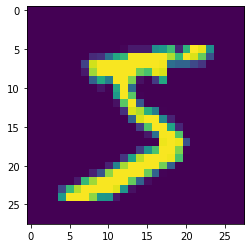

-1.0
1.0
(60000, 28, 28)


In [3]:
print(X_train.shape)
plt.imshow(X_train[0])
plt.show()
#Normalization
X_train = (X_train.astype('float32') - 127.5) / 127.5
print(np.min(X_train))
print(np.max(X_train))
print(X_train.shape) 

In [4]:
TOTAL_EPOCH = 5
BATCH_SIZE = 256
NO_OF_BATCHES = int(X_train.shape[0]/BATCH_SIZE)
HALF_BATCH = 128
NOISE_DIM = 100
adam = Adam(lr = 2e-4, beta_1=0.5)

In [5]:
generator = Sequential()
generator.add(Dense(7 * 7 * 128, input_shape = (NOISE_DIM,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())
#14x14x64
generator.add(Conv2DTranspose(64, kernel_size=(5,5),strides = (2,2),padding = 'same'))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())

#28x28x1

generator.add(Conv2DTranspose(1,  kernel_size=(5,5),strides = (2,2),padding = 'same',activation='tanh'))
generator.compile(loss = 'binary_crossentropy',optimizer = adam)
generator.summary()

W1022 13:52:59.467044 140046609622848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1022 13:52:59.469616 140046609622848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 13:52:59.472456 140046609622848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1022 13:52:59.539874 140046609622848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1022 13:52:59.540764 1400466096

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
__________

In [6]:
descriminator = Sequential()
descriminator.add(Conv2D(64,(5,5),strides = (2,2),padding = 'same',input_shape = (28,28,1)))
descriminator.add(LeakyReLU(0.2))


descriminator.add(Conv2D(128,(5,5),strides = (2,2),padding = 'same'))
descriminator.add(LeakyReLU(0.2))
descriminator.add(Flatten())

descriminator.add(Dense(1,activation = 'sigmoid'))
descriminator.compile(loss = 'binary_crossentropy',optimizer = adam)
descriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trainable params: 212,865
Non-trainable params: 0
_________________________________________________________________


# Gan

In [7]:
descriminator.trainable = False
gan_input = Input(shape = (NOISE_DIM,))
generated_img = generator(gan_input)
gan_output = descriminator(generated_img)

model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer = adam)



# Training Loop

In [ ]:
X_train = X_train.reshape(60000,28,28,1)
print(X_train.shape)
d_losses = []
g_losses = []
for epoch in range(TOTAL_EPOCH):
    epoch_d_loss = 0.
    epoch_g_loss = 0.
    for step in range(NO_OF_BATCHES):
        #Discriminator
        #50% real data + 50% Fake Data
        #Real Data
        idx = np.random.randint(0,X_train.shape[0],HALF_BATCH)
        real_imgs = X_train[idx]
        #Fake data
        noise = np.random.randint(0,1,size = (HALF_BATCH,NOISE_DIM))
        fake_imgs = generator.predict(noise)
        #labels
        real_y = np.ones((HALF_BATCH,1))* 0.9
        #One sided smoothing for descriminator 
        fake_y = np.zeros((HALF_BATCH,1))
        
        #Train Descriminator
        d_loss_real = descriminator.train_on_batch(real_imgs,real_y)
        
        d_loss_fake = descriminator.train_on_batch(fake_imgs,fake_y)
        
        d_loss = 0.5 * d_loss_real + 0.5 * d_loss_fake
        
        epoch_d_loss += d_loss
        
        #Train Generator
        
        noise = np.random.normal(0,1,size = (BATCH_SIZE,NOISE_DIM))
        
        ground_truth_y = np.ones((BATCH_SIZE,1))
        g_loss = model.train_on_batch(noise,ground_truth_y)
        epoch_g_loss += g_loss
    
    print("Epoch %d Discriminator_loss %.4f Generator_loss %.4f"%((epoch+1),epoch_d_loss,epoch_g_loss))
        
    #print("Epoch %d Discriminator_loss %.4f Generator_loss %.4f"%((epoch+1),epoch_d_loss/NO_OF_BATCHES,epoch_g_loss/NO_OF_BATCHES))
    d_losses.append(epoch_d_loss/NO_OF_BATCHES)
    g_losses.append(epoch_g_loss/NO_OF_BATCHES)

    def save_imgs(epoch,samples = 100):
        noise = np.random.normal(0,1,size=(samples,NOISE_DIM))
        generated_imgs = generator.predict(noise)
        generated_imgs = generated_imgs.reshape(samples,28,28)
        plt.figure(figsize = (100,100))
        for i in range(samples):
            plt.plot(50,50,i+1)
            plt.imshow(generated_imgs[i],interpolation = 'nearest',cmap='gray')
            plt.axis("off")
            plt.tight_layout()
            plt.savefig('images/gan_out_epoch{0}.png'.format(epoch+1))
            plt.show()
    if(epoch+1) % 10 == 0:
        generator.save('model/gan_generator1_{0}.h5'.format(save_imgs(epoch) ,epoch+1))
   


(60000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
plt.plot(d_loss,label="DISC")
plt.plot(g_loss, label="GEN")
plt.show()

In [ ]:

idx = np.random.randint(0,X_train.shape[0],HALF_BATCH)
real_imgs = X_train[idx]
real_imgs.shape

In [ ]:
noise = np.random.randint(0,1,size = (HALF_BATCH,NOISE_DIM))
        
noise.shape